In [99]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import spsolve, norm, inv, eigsh
import matplotlib.pyplot as plt
from matplotlib import rc

# rc('text', usetex=True) # para usar latex en matplotlib
import scipy as sp

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Tomás Banduc & Cristóbal Godoy

Miercoles 2 de Abril 2025.

Integrantes - Grupo 9
- Allen Arroyo
- Isidora Miranda
- Iñaki Ramirez

# Laboratorio 1

**Objetivo General:** A través de esta sesión práctica, se busca que el estudiante aprenda a resolver problemas elípticos de EDP en dos-dimensiones aplicando el Método de Diferencias Finitas.

**Objetivo Particular:** Se resolverá la ecuación de Poisson en un cuadrado unitario. Además se estudiará la aproximación de su solución para condiciones de borde en dominios con curvatura, como es el caso del rectángulo perforado.

# Parte I


## Ecuación de Poisson en Dominio Cuadrado

Considere la ecuación del calor en estado estacionario sobre el cuadrado unitario:


\begin{align*}
(P)\quad\left\{
\begin{array}[c]{rll}
-\Delta u= & 0 & \text{sobre }\Omega=\left(  0,1\right)^{2}\\
u(x,0)= & 0 & \text{en }0\leq x\leq 1\\
u(x,1)= & g(x) & \text{en }0\leq x\leq 1\\
u(0,y)= & 0 & \text{en }0< y< 1\\
u(1,y)= & 0 & \text{en }0< y <1
\end{array}
\right.
\end{align*}

donde $g\in\mathcal{C}^1([0,1])$ cumple que $g(0)=g(1)=0$.

Sea $N\in\mathbb{N}$ y $\Omega_h$ el mallado equiespaciado del cuadrado unitario $\Omega$:

\begin{align*}
\Omega_{h}:=\left\{  \left(  x_{j},y_{k}\right)  \mid j,k\in\left\{
0,1,\ldots,N+1\right\}  \right\}, \quad x_j:=j\cdot h, \quad y_k:=k\cdot h
\end{align*}


Para aproximar el operador Laplaciano del problema de Poisson, se define el *Laplaciano Direcretizado* por 5 puntos como:

\begin{align*}
(\Delta_{h}U)_{j,k}=\dfrac{1}{h^{2}}\left(U_{j,k-1}+U_{j-1,k}-4U_{j,k}
+U_{j+1,k}+U_{j,k+1}
\right)
\end{align*}


Buscamos una solución $(u_{j,k})_{j,k\in\{0\,...,N+1\}}$ que cumpla la versión discretizada de $(P)$ inducida por el laplaciano anterior, de modo que $u_{j,k}\simeq u(x_j,y_k)$ para la solución única $u$ de $(P)$.


Tomando $g(x) = \sin(\pi x)$ se puede demostrar que la solución de esta ecuación está dada por:

$$u\left(  x,y\right)  =\dfrac{1}{\sinh\left(  \pi\right)}\cdot\sin\left( \pi x\right)   \sinh\left( \pi y\right) $$

### P1

> **(a)** Escriba dos funciones que calculen $\boldsymbol{A}_{h}$ y $\boldsymbol{b}_{h}$ asociadas al problema lineal equivalente del problema discreto. Las entradas para estas funciones deben ser $N$ y $g$.<br>
<br>
**(b)** Cree una función `solve` que, utilizando estas funciones, y las funciones auxiliares que necesite, entregue la solución aproximada $u_h$ del problema $(P)$.<br>
<br>
**Hint:** Le puede ser útil revisar la documentación del comando `kron` (disponible a través de `scipy.sparse`).

1.  Se leyó https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.kron.html y Lab0.
2.  Dada la definición en el enunciado de tarea 1 pregunta 3 sabemos que los vectores del sistema lineal como $(u_n)^{N^2}_{n=1}$ estan indexados por :
 $$n = (k-1)N + j  \hspace{2mm} ,\text{para} \hspace{2mm} (j,k) \in \{1,..,N\}$$
 Entonces como $b_h := f_h + g_h$ ,donde $g_h = g(x_j)$ si $k =N$,vamos a saber que
 $$ b_{h}[n] = g(x[j]])$$
 Dado que python no parte los arreglos con $i = 1$ sino que con $i=0$ agregaremos un $-1$ tal que $n = (k-1)N + j-1$
3. Codigo de Lab0.



In [100]:
sp.sparse.kron?

In [101]:
# Funcion de borde :
g = lambda x: np.sin(np.pi * x)
# Solucion analitica
u = lambda x,y : (1/np.sinh(np.pi)) * np.sin(np.pi*x) * np.sinh(np.pi*y)

In [102]:
def Ah(N):
    h = 1/(N + 1) # el paso
    h2 = (1/(h**2))

    diag = np.ones(N-1)  # Vector de unos de tamaño N-1
    I = sp.sparse.eye(N, format="csr")  # identidad de NxN en formato csr(Compressed Sparse Row)

    # Construcción de la matriz tridiagonal L4 y Matriz Auxiliar
    # los offset son donde van las diagonales

    DiagAux = np.array([-diag, np.zeros(N), -diag], dtype = object)
    DiagL4 = np.array([-diag, 4*np.ones(N), -diag], dtype = object)

    L4 = sp.sparse.diags(DiagL4, offsets=[-1, 0, 1], format="csr")      # Matriz de NxN
    Aux = sp.sparse.diags(DiagAux, offsets=[-1, 0, 1], format="csr")    # Matriz de NxN

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.kron.html
    # Construcción de A usando productos de Kronecker

    Ah = sp.sparse.kron(I, L4, format="csr") + sp.sparse.kron(Aux, I, format="csr") # Matriz de N^2 x N^2

    return h2*Ah

def bh(N,f,g):
  # np.linspace(start = a, stop = b, num = Nx + 2) # el último parámetro es la cantidad de puntos interior + los extremos.
  x = np.linspace(0, 1, N+2)
  h,bh = 1/(N+1), np.zeros(N**2) # el paso y el vector b_h de N^2 valores
  h2 = 1/(h*h)

  for j in range(1,N+1):
    bh[(N-1)*N+j-1] =  g(x[j])
  return h2*bh

def solve(N, f, g):
    """ Resuelve el problema del laplaciano en 2D en (0,1)^2 con condiciones
    Dirichlet en el borde, usando una grilla uniforme de N puntos interiores, con paso h = 1/(N+1) en x e y.
    """
    h = 1/(N + 1)
    A = Ah(N)
    B = bh(N, f, g)
    aprox = sp.sparse.linalg.spsolve(A,B)

    return aprox

In [103]:
# Ejemplo de solve(N, f, g): Notar que nos entrega un arreglo de N^2 valores
N = 5
sol = solve(3, 0, g)
len(sol), sol

(9,
 array([0.05835298, 0.08252358, 0.05835298, 0.15088835, 0.21338835,
        0.15088835, 0.33181206, 0.46925312, 0.33181206]))

In [104]:
Ah(2).toarray()

array([[36., -9., -9.,  0.],
       [-9., 36.,  0., -9.],
       [-9.,  0., 36., -9.],
       [ 0., -9., -9., 36.]])

In [105]:
# Viszualizacion :

N=2

h = 1/(N + 1) # el paso
h2 = (1/(h**2))

diag = np.ones(N-1)  # Vector de unos de tamaño N-1
I = sp.sparse.eye(N, format="csr")  # identidad de NxN en formato csr(Compressed Sparse Row)

    # Construcción de la matriz tridiagonal L4 y Matriz Suxiliar
    # los offset son donde van las diagonales

DiagAux = np.array([-diag, np.zeros(N), -diag], dtype = object)
DiagL4 = np.array([-diag, 4*np.ones(N), -diag], dtype = object)

L4 = sp.sparse.diags(DiagL4, offsets=[-1, 0, 1], format="csr")      # Matriz de NxN
Aux = sp.sparse.diags(DiagAux, offsets=[-1, 0, 1], format="csr")    # Matriz de NxN
A = sp.sparse.kron(I, L4, format="csr")
B = sp.sparse.kron(Aux,I,format="csr")
A.toarray(), B.toarray()

(array([[ 4., -1.,  0.,  0.],
        [-1.,  4.,  0.,  0.],
        [ 0.,  0.,  4., -1.],
        [ 0.,  0., -1.,  4.]]),
 array([[ 0.,  0., -1.,  0.],
        [ 0.,  0.,  0., -1.],
        [-1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.]]))

### P2

> Resuelva la ecuación para $N\in\{10, 20, 30, 40, 50, 60, 70, ..., 100\}$, mostrando la evolución del error $L^2$ como función de $N$. Grafique la solución aproximada (en tres casos de su elección) y la solución analítica.<br> **Indicación**: Comente sus resultados.

In [106]:
# Funcion de borde :
g = lambda x: np.sin(np.pi * x)
# Solucion analitica
u = lambda x,y : (1/np.sinh(np.pi)) * np.sin(np.pi*x) * np.sinh(np.pi*y)

In [107]:
# Observación  :

x,y = np.linspace(0, 1, 4), np.linspace(0, 1, 4)
X2, Y2 = np.meshgrid(x, y)  # Crea malla de puntos
u_real_2 = u(X2, Y2)  # Evaluar la función en la malla

# Notar que u_real_2 entrega una matriz de N*N
u_real_2.shape,u_real_2

((4, 4),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.36884599e-02, 9.36884599e-02, 1.32484881e-17],
        [0.00000000e+00, 2.99856822e-01, 2.99856822e-01, 4.24027628e-17],
        [0.00000000e+00, 8.66025404e-01, 8.66025404e-01, 1.22464680e-16]]))

In [108]:
# Observación  :

x,y = np.linspace(0, 1, 4), np.linspace(0, 1, 4)
X1, Y1 = np.meshgrid(x, y, indexing = 'ij')
u_real_1 = u(X1, Y1)

u_real_1.shape,u_real_1

((4, 4),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.36884599e-02, 2.99856822e-01, 8.66025404e-01],
        [0.00000000e+00, 9.36884599e-02, 2.99856822e-01, 8.66025404e-01],
        [0.00000000e+00, 1.32484881e-17, 4.24027628e-17, 1.22464680e-16]]))

In [109]:
# np.meshgrid(x, y) e np.meshgrid(x, y, indexing = 'ij') son diferentes
X1 == X2

array([[ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False, False,  True]])

In [110]:
# Ejemplo pequeño :

x = [1,2]
y = [3,4]

X, Y = np.meshgrid(x, y, indexing = 'ij')
X,Y

(array([[1, 1],
        [2, 2]]),
 array([[3, 4],
        [3, 4]]))

In [111]:
S = u(X,Y)
S

array([[ 6.57015076e-14,  1.52037840e-12],
       [-1.31403015e-13, -3.04075680e-12]])

In [112]:
S.flatten('F')

array([ 6.57015076e-14, -1.31403015e-13,  1.52037840e-12, -3.04075680e-12])

In [113]:
S

array([[ 6.57015076e-14,  1.52037840e-12],
       [-1.31403015e-13, -3.04075680e-12]])

Observación :

 tiene $u_{aprox} \in \mathbb{R}^{NxN}$ y $u_{real} \in \mathbb{R^{N^2}}$, por lo que se debe transformar un elemento a la dimensión del otro.

In [114]:
# Para calcular el error:

Error_L2 = []

for N in range(10, 100+1, 10):  # incrementa de 10 en 10
    x,y = np.linspace(0, 1, N), np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y, indexing = 'ij')

    # Si se desea cambiar u_aprox :
    # Si debe convertir a matriz con .reshape((N,N),order='F').

    u_aprox = solve(N, 0, g)
    u_aprox = solve(N, 0, g).reshape((N,N),order='F') # Esto fue con ayuda de ChatGPT.

    # Si se desea cambiar u_real:
    # Notar que u_real entrega una matriz de NxN, no un vector de N**2 valores. Debemos concatenar las columnas, esto se puede hacer con .flatten('F')
    # par obtener un vector de N**2 valores igual que u_aprox.

    u_real = u(X, Y)
    #u_real = u_real.flatten('F')  # Esto fue con ayuda de ChatGPT.


    Error_L2 += [np.linalg.norm(u_real-u_aprox , 2)/(N+1)] # De Lab 0

Convertir a matriz NxN con orden por columnas


```
matriz = np.reshape(vector, (N, N), order='F')
```




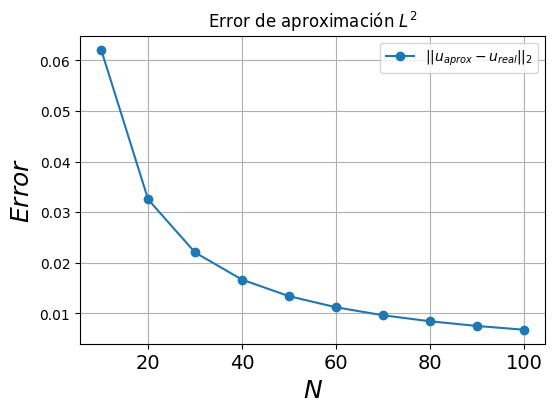

In [115]:
val_N = [10,20,30,40,50,60,70,80,90,100]

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(val_N , Error_L2, linestyle = "-", label = r"$ ||u_{aprox}-u_{real}||_{2} $", marker="o")
ax.set_xlabel("$N$", fontsize = 18)
ax.set_ylabel("$Error$", fontsize = 18)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_title("Error de aproximación $L^2$", fontsize = 12)
ax.legend(loc = "upper right")
ax.grid(True)

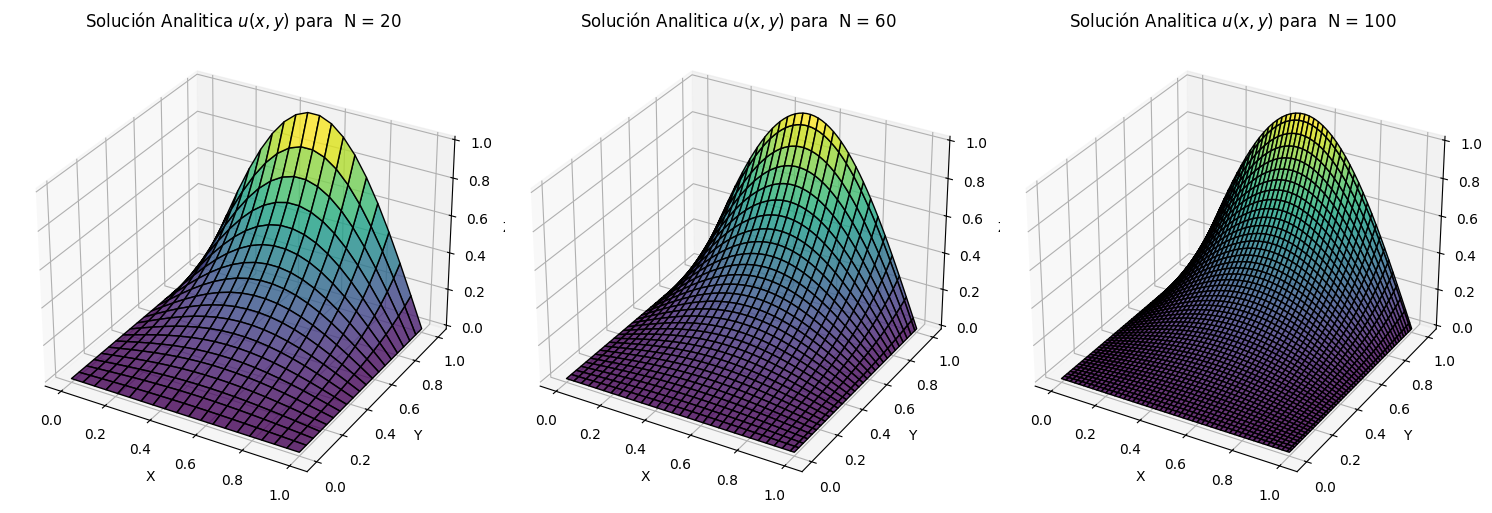

In [116]:
# Solución Analitica :
# Esto es de ChatGPT.

from mpl_toolkits.mplot3d import Axes3D

# Valores de N
N_values = [20, 60, 100]

# Crear la figura y los subgráficos
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})

for ax, N in zip(axes, N_values):
    # Definir x, y y generar la malla
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    Z = u(X, Y)

    # Graficar la superficie
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.8)

    # Título de cada gráfico
    ax.set_title("Solución Analitica $u(x,y)$ para " + " "f'N = {N}')

    # Etiquetas
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

# Ajustar el layout
plt.tight_layout()
plt.show()

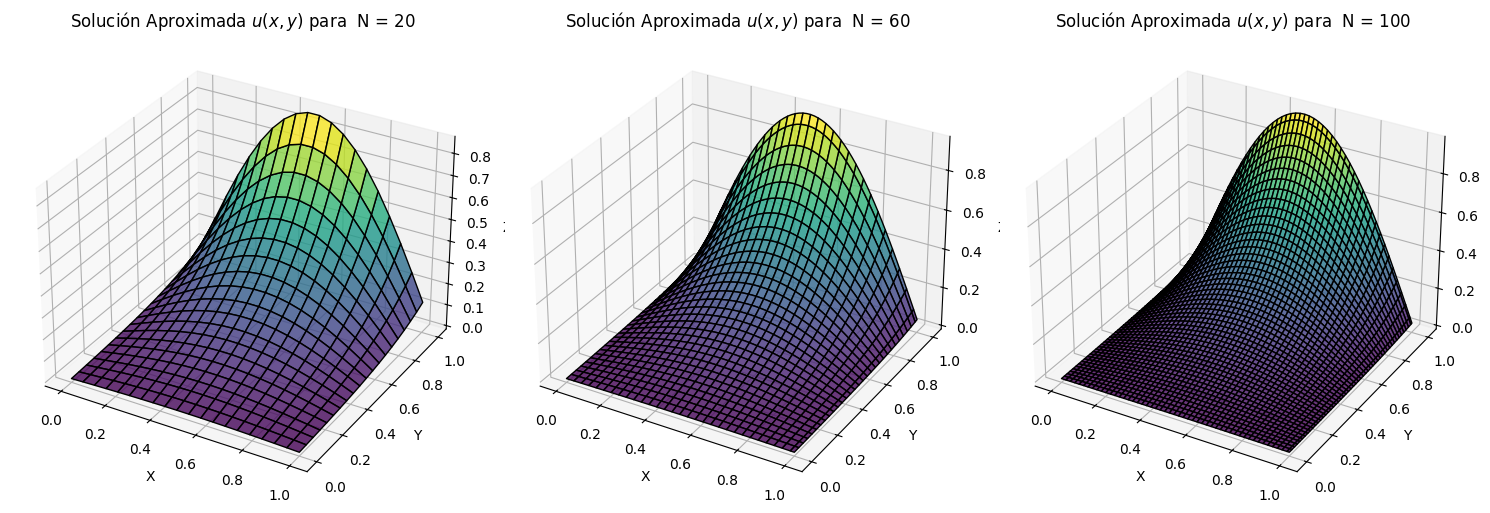

In [117]:
# Valores de N
N_values = [20, 60, 100]

# Crear la figura y los subgráficos
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})

for ax, N in zip(axes, N_values):
    # Definir x, y y generar la malla
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    u_aprox = solve(N, 0, g)
    u_aprox = solve(N, 0, g).reshape((N,N),order='F')
    Z = u_aprox

    # Graficar la superficie
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.8)

    # Título de cada gráfico
    ax.set_title("Solución Aproximada $u(x,y)$ para " + " "f'N = {N}')

    # Etiquetas
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

# Ajustar el layout
plt.tight_layout()
plt.show()

Comentarios de resultados :

Las soluciones aproximadas para $N \in \{20,60,100\}$ corresponden a una buena aproximació de la solución analitica.




Sean $p\in\left[  1,+\infty\right]  $ y $\boldsymbol{A}\in\mathbb{R}^{N\times N}$. Se define la norma inducida $p$ de $\boldsymbol{A}$ como:

\begin{align*}
\left\Vert \boldsymbol{A}\right\Vert _{p}=\sup\limits_{\boldsymbol{x\in}\mathbb{R}^{N}\setminus\left\{  \boldsymbol{0}\right\}  }\dfrac{\left\Vert\boldsymbol{Ax}\right\Vert _{p}}{\left\Vert \boldsymbol{x}\right\Vert_{p}}
\end{align*}

Si $\boldsymbol{A}$ es invertible, se define el número de condición en norma inducida $p$ como:

\begin{align*}\operatorname{cond}_{p}\left(  \boldsymbol{A}\right)  =\left\Vert
\boldsymbol{A}\right\Vert _{p}\left\Vert \boldsymbol{A}^{-1}\right\Vert _{p}\end{align*}

### P3
> Estudie el condicionamiento en norma $2$ de la Matriz $A_h$. En particular, determine su orden de crecimiento respecto a $N$.

**Observación:** En el caso particular de $\boldsymbol{A}_{h}$, dado que la matriz es simétrica, su número de condición en norma $2$ inducida puede calcularse mediante sus valores propios de mayor y menor magnitud:

\begin{align*}
\operatorname{cond}_{2}\left(  \boldsymbol{A}_{h}\right)  =\dfrac{\lambda_{\max,h}\left(  \boldsymbol{A}_{h}\right)  }{\lambda_{\min,h}\left(\boldsymbol{A}_{h}\right)}
\end{align*}

donde $\lambda_{\max,h}\left(  \boldsymbol{A}_{h}\right) :=\max\left\{\left\vert \lambda\right\vert \mid\lambda\in\sigma\left(  \boldsymbol{A}_{h}\right)  \right\}  $ y $\lambda_{\min,h}\left(  \boldsymbol{A}_{h}\right)
:=\min\left\{  \left\vert \lambda\right\vert \mid\lambda\in\sigma\left(\boldsymbol{A}_{h}\right)  \right\}  $.

In [118]:
from scipy.sparse.linalg import eigsh

In [119]:
sp.sparse.linalg.eigsh?



```
scipy.sparse.linalg.eigsh(A, k=6, M=None, sigma=None, which='LM', v0=None,
ncv=None, maxiter=None, tol=0, return_eigenvectors=True,
Minv=None, OPinv=None, mode='normal')
```

-  k: Número de autovalores y autovectores que se desean calcular. Debe ser menor que el tamaño de la matriz.

- 'LM' (default): autovalores de mayor magnitud (largest magnitude).
-'SM': autovalores de menor magnitud (smallest magnitude).
- 'LA': los autovalores más grandes (largest algebraic).
- 'SA': los   autovalores más pequeños (smallest algebraic)

In [120]:
# Ejemplo :
N = 2
sp.sparse.linalg.eigsh(Ah(N), k=1, which='LM',  tol=0)


(array([54.]),
 array([[ 0.5],
        [-0.5],
        [-0.5],
        [ 0.5]]))

In [121]:
def cond_2_sparse(A):
    """
    Calcula el numero de condicionamiento en norma inducida 2
    para una matriz sparse simetrica A.
    Se obtiene como el valor propio de mayor módulo dividido por el de menor módulo

    Input:
    - A matriz sparse simetrica

    Documentacion de eigsh:
    https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.sparse.linalg.eigsh.html
    """
    autoval_max = sp.sparse.linalg.eigsh(A, k=1, which='LM',  tol=0)[0]
    autoval_min = sp.sparse.linalg.eigsh(A, k=1, which='SM', tol=0)[0]
    cond2  = abs(autoval_max[0])/abs(autoval_min[0])

    return cond2

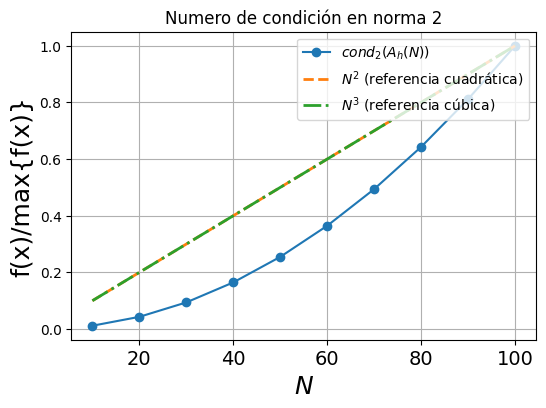

In [122]:
# Grafico para varios Ns no en escala log

val_N = np.array([10,20,30,40,50,60,70,80,90,100])
y = list(map(cond_2_sparse, map(Ah,val_N))) #chatpgt
y_normalized = y/np.max(y) #chatgpt

x = val_N
y_x2 = (x*2) / np.max(x*2)
y_x3 = (x*3) / np.max(x*3)

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(val_N , y_normalized, linestyle = "-", label = r"$ cond_2(A_h(N)) $", marker="o")
ax.plot(x, y_x2, linestyle="--", linewidth=2, label=r"$N^2$ (referencia cuadrática)")
ax.plot(x, y_x3, linestyle="-.", linewidth=2, label=r"$N^3$ (referencia cúbica)")

ax.set_xlabel("$N$", fontsize = 18)
ax.set_ylabel("f(x)/max{f(x)}", fontsize = 18)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_title("Numero de condición en norma 2", fontsize = 12)
ax.legend(loc = "upper right")
ax.grid(True)

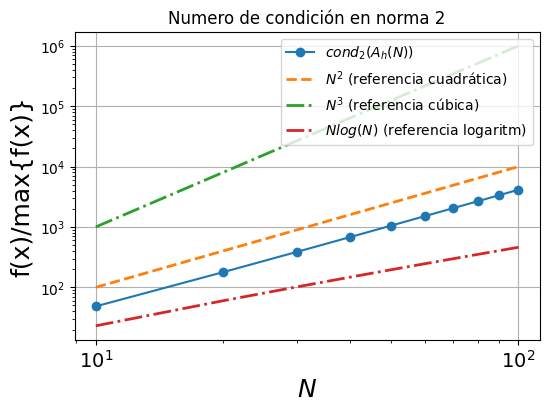

In [123]:
# Grafico para varios Ns escala log
val_N = np.array([10,20,30,40,50,60,70,80,90,100])
y = list(map(cond_2_sparse, map(Ah,val_N)))

x = val_N
y_x2 = (x**2)
y_x3 = (x**3)
y_xlog = (x*np.log(x))

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(val_N , y, linestyle = "-", label = r"$ cond_2(A_h(N)) $", marker="o")
ax.plot(x, y_x2, linestyle="--", linewidth=2, label=r"$N^2$ (referencia cuadrática)")
ax.plot(x, y_x3, linestyle="-.", linewidth=2, label=r"$N^3$ (referencia cúbica)")
ax.plot(x, y_xlog, linestyle="-.", linewidth=2, label=r"$Nlog(N)$ (referencia logaritm)")

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("$N$", fontsize = 18)
ax.set_ylabel("f(x)/max{f(x)}", fontsize = 18)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_title("Numero de condición en norma 2", fontsize = 12)
ax.legend(loc = "upper right")
ax.grid(True)

Comentarios de resultados :

Notemos que el orden del numero de condicionamiento en norma 2 es inferior a $N^2$.

# Parte II

## Ecuación de Poisson en Dominio Perforado

Para $\Omega = (0, 1)^2\backslash B ((0.5, 0.5), 0.3)$, considere el siguiente problema:

\begin{align*}
\left(  P \right)  \left\{
\begin{array}
[c]{rl}
-\Delta u(x,y)=&0,  & \text{si }(x,y)\text{ en }\Omega \\
u(x,y)=&g(x,y), & \text{si} (x,y)\text{ en }\partial\Omega
\end{array}
\right.
\end{align*}

donde $g$ viene dada por:

\begin{align*}
g\left(  x,y\right)  =\left\{
\begin{array}
[c]{rl}
2, &\text{si }(x,y) \in \partial (0,1)^2 \\
0, &\text{si }(x,y) \in \partial B ((0.5, 0.5), 0.3)
\end{array}
\right.
\end{align*}






### P1

> Programe una función que reciba un punto de la malla $(x_j , y_k)$ y entregue como resultado $1$ si es un punto interior al cual se le puede calcular $\Delta u$ con la aproximación utilizada en la fórmula de $5$ puntos, y $0$ si no.

Recordemos que $x_j = h \cdot j$ e $y_k = h \cdot k$ , con $h = \frac{1}{N+1}$, donde el centro de la malla es $(x,y) = (\frac{1}{2},\frac{1}{2})$ y la perforación es de radio $0,3$, por lo que los puntos que tienen sentido para  aproximar el laplaciano son tales que estan en norma mayor que $0.3$ del centro y hasta llegar al borde exterior del conjunto $(0,1)^2$

In [124]:
def interior(N,j,k):
  h = 1/(N+1)
  origen=np.array([0.5, 0.5])
  punto=np.array([j*h,k*h])

  if np.linalg.norm(punto-origen)<0.3:
    return 0
  else:
    return 1

In [125]:
# En verdad acá faltaría agregar + interior(N,j,k) en : interior(N,j-h,k)+interior(N,j+h,k)
# pero luego en la construccion de la matriz no es necesario pues antes ya tenemos una condicón tipo :
# if interior(N,j,k) == 1.

def laplaciano_x(N,j,k):
  h=1/(N+1)
  if  interior(N,j-h,k)+interior(N,j+h,k) == 2:
    return 1
  else:
    return 0

def laplaciano_y(N,j,k):
  h=1/(N+1)
  if  interior(N,j,k-h)+interior(N,j,k+h) == 2:
    return 1
  else:
    return 0


def laplaciano(N,j,k):
  if laplaciano_x(N,j,k)+laplaciano_y(N,j,k)==2:
    return 1
  else:
    return 0

### P2

> Asuma que la matriz del sistema es de la forma $A_h = A_{h,x} + A_{h,y}$, donde $A_{h,x}$ tiene los coeficientes adecuados
para la aproximación de la derivada parcial según $x$, y $A_{h,y}$ los valores necesarios para estimar la derivada parcial en $y$. Encuentre la forma
que deben tener $A_{h,x}$ y $A_{h,y}$ y elabore funciones que calculen dichas matrices. <br> <br>
**Hint 1:** Se sugiere segmentar el problema de programación lo más posible: Puede usar las funciones auxiliares que estime convenientes.<br>
**Hint 2:** Tenga en cuenta las fórmulas explícitas de los coeficientes $\alpha,\beta$ y $\gamma$ de la interpolación del mallado vista para dominio perforado.


Dado el siguiente sistema para la variable $x$

\begin{array}{ll}
  \alpha+\beta+\gamma =0  \\
  \alpha h - \gamma |x^{B}-x^{P}| =0   \\
  \alpha\frac{h^{2}}{2}+\gamma\frac{|x^{B}-x^{P}|^{2}}{2} =1
\end{array}

Podemos despejar $\gamma$ tal que :
$$ \gamma = \frac{\alpha h}{ |x^{B}-x^{P}|}$$
Mientras que $\alpha$ es : $$ \alpha\frac{h^{2}}{2}+ \alpha h\frac{|x^{B}-x^{P}|}{2} =1 $$
$$ \alpha = \frac{2}{h^2 + h \cdot |x^{B}-x^{P}|}$$
Y $$\beta = -\alpha -\gamma$$

Es analogo para la variable $y$.

In [126]:
# Para calcular los parametros :

def parametros(N,xB,xP,coordenada) :
  h = 1/(N+1)
  if coordenada =="x" :
    distancia = np.abs(xB[0]-xP[0])
    alpha = 2/(h**2 + h * distancia) # antes acá habia un error
    gamma  = (alpha*h)/distancia
    beta =-gamma -alpha

  if coordenada =="y" :
    distancia = np.abs(xB[1]-xP[1])
    alpha = 2/(h**2 + h*distancia) # antes acá habia un error
    gamma  = (alpha*h)/distancia
    beta =-gamma -alpha
  return alpha,beta,gamma


In [127]:
# Recordemos la funcion de la primera parte :
def Ah(N):
    h = 1/(N + 1) # el paso
    h2 = (1/(h**2))

    diag = np.ones(N-1)  # Vector de unos de tamaño N-1
    I = sp.sparse.eye(N, format="csr")  # identidad de NxN en formato csr(Compressed Sparse Row)

    DiagAux = np.array([-diag, np.zeros(N), -diag], dtype = object)
    DiagL4 = np.array([-diag, 4*np.ones(N), -diag], dtype = object)

    L4 = sp.sparse.diags(DiagL4, offsets=[-1, 0, 1], format="csr")      # Matriz de NxN
    Aux = sp.sparse.diags(DiagAux, offsets=[-1, 0, 1], format="csr")    # Matriz de NxN

    Ah = sp.sparse.kron(I, L4, format="csr") + sp.sparse.kron(Aux, I, format="csr") # Matriz de N^2 x N^2

    return h2*Ah

Ahora la dividimos tal que $A_h = A_{h,x} +A_{h,y}$

In [128]:
def Ahx(N):
    h = 1/(N + 1) # el paso
    h2 = (1/(h**2))

    diag = np.ones(N-1)  # Vector de unos de tamaño N-1
    Diag = np.array([-diag, np.zeros(N), -diag], dtype = object)

    I = sp.sparse.eye(N, format="csr")  # identidad de NxN en formato csr(Compressed Sparse Row)

    Aux = sp.sparse.diags(Diag, offsets=[-1, 0, 1], format="csr")    # Matriz de NxN
    L2 = Aux + 2*I

    A = sp.sparse.kron(I, L2, format="csr")
    return h2*A

def Ahy(N):
    h = 1/(N + 1) # el paso
    h2 = (1/(h**2))

    diag = np.ones(N-1)  # Vector de unos de tamaño N-1
    Diag = np.array([-diag, np.zeros(N), -diag], dtype = object)

    I = sp.sparse.eye(N, format="csr")  # identidad de NxN en formato csr(Compressed Sparse Row)

    Aux = sp.sparse.diags(Diag, offsets=[-1, 0, 1], format="csr")    # Matriz de NxN

    A = sp.sparse.kron(I, 2*I, format="csr") + sp.sparse.kron(Aux, I, format="csr")  # Matriz de N^2 x N^2

    return h2*A

In [129]:
def Ahx_modifcada(N):
    h = 1/(N+1)
    A = Ahx(N)
    A = A.todense()

    for j in range(1,N+1) :
      for k in range(1,N+1) :
        n = (k-1)*N + j-1 # la indexación para la matriz A, leer enunciado de tarea se resta 1 porque python parte de 0.
        xP = np.array([j*h,k*h])

        if interior(N,j,k) == 1 : # El punto (j*h,k*h) está en el dominio
          if laplaciano_x(N,j,k) == 0 :
              if interior(N,j-h,k) == 0 : # el punto que complica es por la izquierda

               H = np.sqrt(0.3**2-(xP[1]-1/2)**2) # esto se calcula con pitagoras donde H := xB[0] respecto al centro (1/2,1/2).
               xB0 = H + 1/2
               xB = [xB0,xP[1]]
               alpha,beta,gamma = parametros(N,xB,xP,"x")

               A[n,n-1] = 0
               A[n,n] = beta
               A[n,n+1] = alpha

              if interior(N,j+h,k) == 0 : # el punto que complica es por la derecha
               H = np.sqrt(0.3**2-(xP[1]-1/2)**2) # esto se calcula con pitagoras donde H := xB[0] respecto al centro (1/2,1/2).
               xB0 = 1/2 - H # Notar que cambia en el caso que el pto malo es por la derecha
               xB = [xB0,xP[1]]
               alpha,beta,gamma = parametros(N,xB,xP,"x")

               A[n,n-1] = alpha
               A[n,n] = beta
               A[n,n+1] = 0
        if  interior(N,j,k) == 0 : # El punto (j*h,k*h) está fuera del dominio
               A[n,:] = 0
               A[:,n] = 0
               A[n,n] = 1

    matriz = sp.sparse.csr_matrix(A)
    return matriz

def Ahy_modificada(N):
    A = Ahy(N)
    A = A.todense()
    h = 1/(N+1)

    for j in range(1,N+1) :
      for k in range(1,N+1) :
        n = (k-1)*N + j - 1
        xP = np.array([j*h,k*h])
        if interior(N,j,k) == 1 :
          if laplaciano_y(N,j,k) == 0 :
              if interior(N,j,k+h) == 1 : # el punto que complica es por arriba.
                # r^2 = y^2 + x^2 ; donde "r = 0.3" es el radio, "y" la coordenda de xB[1] respecto al centro (1/2,1/2),
                # y x es la coordenada de xB[0] respecto al centro  (1/2,1/2).
                y = np.sqrt(0.3**2-(xP[0]-1/2)**2) # esto se calcula con pitagoras donde H = xB[0] respecto al centro (1/2,1/2).
                xB1 = 1/2 - y # Se centra rescecpto al centro (0,0)
                xB = [xP[0],xB1] # Notar que la coordenada "x" de B y P son la misma
                alpha,beta,gamma = parametros(N,xB,xP,"y")

                A[n,n-N] = alpha
                A[n,n] = beta
                A[n,n+N] =  0
              if interior(N,j,k-h) == 0 : # el punto que complica es por abajo.
                # r^2 = y^2 + x^2 ; donde "r = 0.3" es el radio, "y" la coordenda de xB[1] respecto al centro (1/2,1/2),
                # y x es la coordenada de xB[0] respecto al centro  (1/2,1/2).
                y = np.sqrt(0.3**2 - (xP[0] -1/2)**2) # esto se calcula con pitagoras
                xB1 = y + 1/2 # para centrarla en el centro (0,0)
                xB = [xP[0],xB1] # Notar que la coordenada "x" de B y P son la misma
                alpha,beta,gamma = parametros(N,xB,xP,"y")

                A[n,n-N] = 0
                A[n,n] = beta
                A[n,n+N] = alpha
        if interior(N,j,k) == 0 :
                A[n,:] = 0
                A[:,n] = 0
                A[n,n] = 1
    matriz = sp.sparse.csr_matrix(A)
    return matriz

### P3
> Escriba una función que calcule $b_h$ adaptado a este caso.

In [130]:
# En la frontera exterior es 2 y en la interior es 0

def bh(N):
  h = 1/(N+1)
  x = np.linspace(0, 1, N+2)
  b = np.zeros(N*N)

  for k in range(1,N+1):
    b[(k-1)*N] = 2
    b[(k-1)*N+N-1] = 2

  for j in range(1,N+1):
    b[j-1] = 2
    b[(N-1)*N-1+j] = 2

  return (1/h**2)*b

### P4
>Resuelva el sistema $A_h u_h = b_h$ asociado a la discretización del dominio perforado, grafique la solución aproximada para $N\in\{10, 20, 30, 40, 50\}$.
<br> **Indicación:** Comente sus resultados.

In [131]:
def solve2(N):
  A = Ahx_modifcada(N) + Ahy_modificada(N)
  B = bh(N)
  aprox = sp.sparse.linalg.spsolve(A,B)

  return aprox

In [132]:
#Ejemplo :
solve2(5)

array([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 1., 1., 1., 1.])

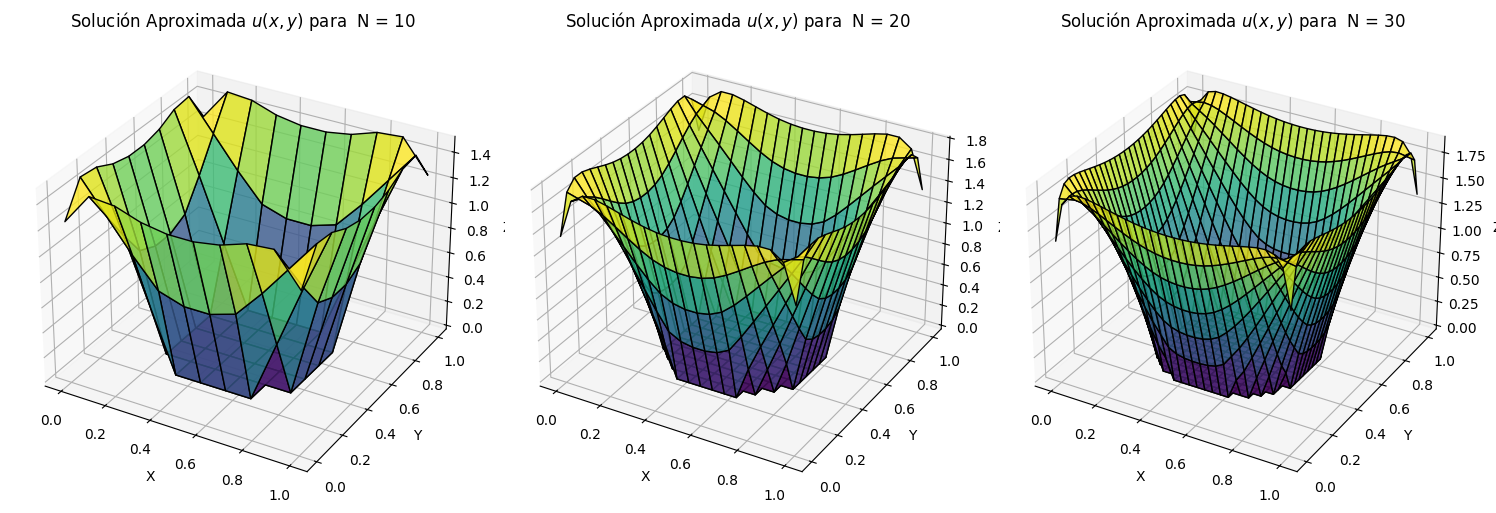

In [133]:
# Valores de N
N_values = [10, 20, 30]

# Crear la figura y los subgráficos
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})

for ax, N in zip(axes, N_values):
    # Definir x, y y generar la malla
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    u_aprox = solve2(N)
    u_aprox = u_aprox.reshape((N,N),order='F')
    Z = u_aprox

    # Graficar la superficie
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.8)

    # Título de cada gráfico
    ax.set_title("Solución Aproximada $u(x,y)$ para " + " "f'N = {N}')

    # Etiquetas
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

# Ajustar el layout
plt.tight_layout()
plt.show()

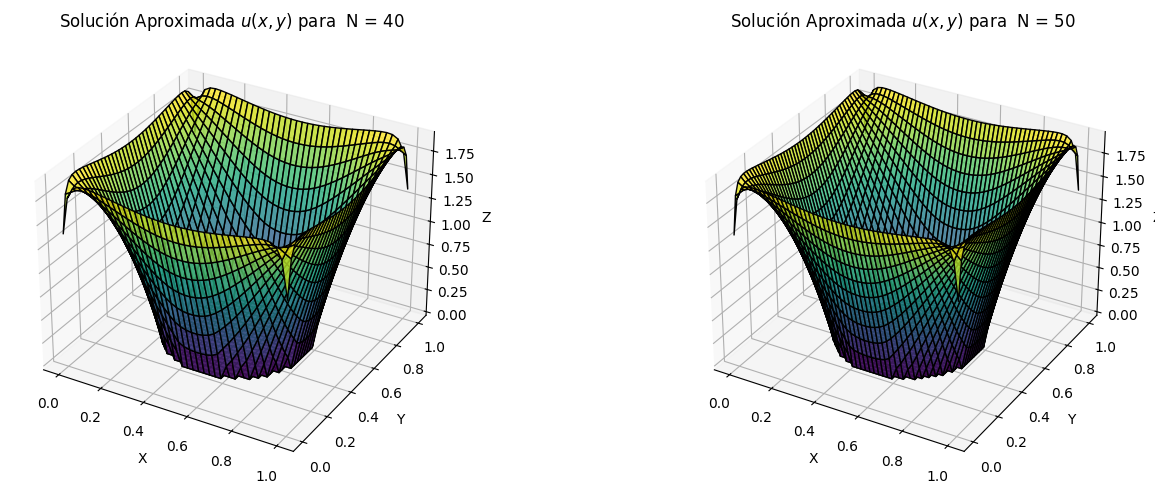

In [134]:
# Valores de N
N_values = [40, 50]

# Crear la figura y los subgráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': '3d'})

for ax, N in zip(axes, N_values):
    # Definir x, y y generar la malla
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    u_aprox = solve2(N)
    u_aprox = u_aprox.reshape((N,N),order='F')
    Z = u_aprox

    # Graficar la superficie
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.8)

    # Título de cada gráfico
    ax.set_title("Solución Aproximada $u(x,y)$ para " + " "f'N = {N}')

    # Etiquetas
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

# Ajustar el layout
plt.tight_layout()
plt.show()

Comentarios de resultados :

La solución aproximada para todos los $N$ tiene sentido pues en el centro existe la perforación del dominio, y vemos en los graficos que los valores de la aproximación decrecen a 0 al llegar a las coordenaas de la perforación.

### P5
>Muestre qué sucede con el condicionamiento de la matriz utilizando la fórmula de valores propios de la Parte I. ¿Es dicha fórmula válida en este caso? ¿Cómo adaptaría su código para $f\neq 0$?

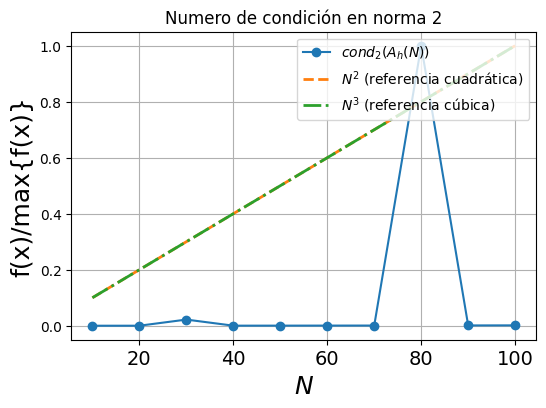

In [140]:
# Grafico para varios Ns no en escala log

val_N = np.array([10,20,30,40,50,60,70,80,90,100])
resultados_ahx = map(Ahx_modifcada, val_N)
resultados_ahy = map(Ahy_modificada, val_N)
sumas = (x + y for x, y in zip(resultados_ahx, resultados_ahy))
y = list(map(cond_2_sparse, sumas))
y_normalized = y/np.max(y) #chatgpt

x = val_N
y_x2 = (x*2) / np.max(x*2)
y_x3 = (x*3) / np.max(x*3)

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(val_N , y_normalized, linestyle = "-", label = r"$ cond_2(A_h(N)) $", marker="o")
ax.plot(x, y_x2, linestyle="--", linewidth=2, label=r"$N^2$ (referencia cuadrática)")
ax.plot(x, y_x3, linestyle="-.", linewidth=2, label=r"$N^3$ (referencia cúbica)")

ax.set_xlabel("$N$", fontsize = 18)
ax.set_ylabel("f(x)/max{f(x)}", fontsize = 18)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_title("Numero de condición en norma 2", fontsize = 12)
ax.legend(loc = "upper right")
ax.grid(True)

Luego, se observa que la formula de condicionamiento para este caso no es valida pues la matriz $A_h$ en este caso no es simétrica, lo cual se debe a que el calculo de la doble derivada ($u_{xx}, u_{yy}$)en algún punto donde falla uno de los 4 puntos, es decir, que no pertenece al dominio de estudio, se debe reemplazar en la matriz en esa coordenada, $\alpha$, $\beta$, $\gamma$ o $0$, por lo que puede generar complicaciones para usar la función previamente definida.

Luego, para adaptar el código, se debe modificar el $b_h$, sumandole un vector $f_h$ con $(f_h)_n= f_h(x_j,y_k)$ con la indexación vista en la parte I, de manera que los puntos interiores del cuadrado y afuera de la circunferencia se igualara $f$.